In [91]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

# load catalog

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'

In [3]:
catalog = fio.read(catalog_path)

In [4]:
catalog_cluster = catalog[catalog['LOC'] == 1]

In [5]:
catalog_field = catalog[catalog['LOC'] == 0]

# raw rendering script hardcoded

In [170]:
def partition(lst, n):
    """
    Divides a list into N roughly equal chunks
    Examples
    --------
    Define some test list, and look at the obtained chunks with different :code:`n` values::
        >>> lst = np.arange(20)
        >>> lst
        array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19])
        >>> partition(lst, n=5)
        [array([0, 1, 2, 3]),
         array([4, 5, 6, 7]),
         array([ 8,  9, 10, 11]),
         array([12, 13, 14, 15]),
         array([16, 17, 18, 19])]
        >>> partition(lst, n=6)
        [array([0, 1, 2]),
         array([3, 4, 5, 6]),
         array([7, 8, 9]),
         array([10, 11, 12]),
         array([13, 14, 15, 16]),
         array([17, 18, 19])]
    As we can see, even when :code:`n` is not a divisor of :code:`len(lst)`, it returns
    roughly balanced chunks
    Parameters
    ----------
    lst : list
        list to split up
    n : int
        chunks to make
    Returns
    -------
    list of lists
        list of chunks
    """
    division = len(lst) / float(n)
    return [lst[int(round(division * i)): int(round(division * (i + 1)))]
            for i in range(n) ]

In [285]:
class DrawField(object):
    def __init__(self, canvas_size, catalog, band="g", pixel_scale = 0.264, sky_level = 1.e2, psf_fwhm = 0.9):
        """
        This assumes a gaussian PSF
        """
        self.canvas_size = canvas_size
        self.canvas_cen = np.array((canvas_size / 2., canvas_size / 2.))
        self.catalog = catalog
        self.band = band
        self.pixel_scale = pixel_scale
        self.sky_level = sky_level
        self.psf_fwhm = psf_fwhm
        
        self.stamps = []
        self.stamps_bounds = []
        self.positions = []
        self.offsets = []
        
    def make_canvas(self):
        self.xx = self.catalog['X'] - self.canvas_size / 2
        self.yy = self.catalog['X'] - self.canvas_size / 2
        self.canvas = galsim.ImageF(self.canvas_size, self.canvas_size, scale=self.pixel_scale)
        self.canvas.array[:, :] = 0 # this might be redundant
        
    def make_psf(self):
        self.psf = galsim.Gaussian(fwhm=self.psf_fwhm)
    
    def make_bdf_pars(self):
        self.bdf_pars = np.zeros((len(self.catalog), 7))
        # There might be a way to add xoffset and yoffset here also as 0 and 1 element
        self.bdf_pars[:, 2] = self.catalog["G1"][:]
        self.bdf_pars[:, 3] = self.catalog["G2"][:]
        self.bdf_pars[:, 4] = self.catalog["TSIZE"][:]
        self.bdf_pars[:, 5] = self.catalog["FRACDEV"][:]
        self.bdf_pars[:, 6] = self.catalog["FLUX_" + self.band.upper()][:]
        
        
    
    def make_positions(self):
        
        self.xx = catalog['X'][:] - self.canvas_cen[0]
        self.yy = catalog['Y'][:] - self.canvas_cen[1]
        
        self.x_cen = np.floor(self.xx)
        self.y_cen = np.floor(self.yy)

        self.offsets = np.vstack((self.xx - self.x_cen, self.yy - self.y_cen)).T
    
    
    def prepare(self):
        self.make_canvas()
        self.make_psf()
        self.make_bdf_pars()
        self.make_positions()
    
    def make_infodicts(self):
        """Prepare instruction set dictionaries to be passed for multiprocessing calculations"""
        self.infodicts = []
        for i in np.arange(len(self.catalog)):
            info = {
                "id": i,
                "bdf_pars": self.bdf_pars[i],
                "psf": self.psf,
                "pixel_scale": self.pixel_scale,
                "x_cen": self.x_cen[i],
                "y_cen": self.y_cen[i],
                "offset": self.offsets[i]
            }
            self.infodicts.append(info)
        
    
    @staticmethod
    def draw_info(info):
        bdf_pars = info["bdf_pars"]
        psf = info["psf"]
        pixel_scale = info["pixel_scale"]
        x_cen = info["x_cen"]
        y_cen = info["y_cen"]
        offset = info["offset"]
        
        galmaker = ngmix.gmix.GMixBDF(bdf_pars)
        gs_profile = galmaker.make_galsim_object()
        final_gal = galsim.Convolve([psf, gs_profile])
        stamp_size = final_gal.getGoodImageSize(pixel_scale)
        
        
        bound = galsim.BoundsI(x_cen - stamp_size / 2 + 1  , x_cen + stamp_size/ 2,
                           y_cen - stamp_size / 2 + 1,  y_cen + stamp_size / 2)
        
        stamp = galsim.ImageF(bound, scale=pixel_scale, )
        final_gal.drawImage(stamp, offset=offset,)
        
        return stamp, bound, info["id"]
    
#     def _draw_object(self, i):
#         """
#         here we make a separate stamp, so that no reference writing is needed
        
#         return stamp
#         """
    
#         galmaker = ngmix.gmix.GMixBDF(self.bdf_pars[i])
#         gs_profile = galmaker.make_galsim_object()
#         final_gal = galsim.Convolve([self.psf, gs_profile])
#         stamp_size = final_gal.getGoodImageSize(self.pixel_scale)
#         stamp = galsim.ImageF(stamp_size, stamp_size, scale=self.pixel_scale)
        
#         xx = catalog['X'][i] - self.canvas_cen[0]
#         yy = catalog['Y'][i] - self.canvas_cen[1]
#         x_cen = np.floor(xx)
#         y_cen = np.floor(yy)

#         offset = (xx - x_cen, yy - y_cen)
        
#         bound = galsim.BoundsI(x_cen - stamp_size / 2 + 1  , x_cen + stamp_size/ 2,
#                            y_cen - stamp_size / 2 + 1,  y_cen + stamp_size / 2)
#         #sub_gal_image = canvas[b]
#         final_gal.drawImage(stamp, offset=offset, add_to_image=True)
        
#         self.stamps.append(stamp)
#         self.stamps_bounds.append(bound)
#         self.positions.append((xx, yy))
#         self.offsets.append(offset)
        
#         return stamp

    
    def call_chunks(self, infodicts):
        """Technically this is inside the multiprocessing call, so it should not change any self properties"""
        stamps = []
        bounds = [] 
        ids = []
        for info in infodicts:
            stamp, bound, i = self.draw_info(info)
            stamps.append(stamp)
            bounds.append(bounds)
            ids.append(i)
            
        return stamps, bounds, ids
        
    
    def multi_render(self, nprocess=1):
        """
        OpenMP style parallelization for xshear tasks
        Separates tasks into chunks, and passes each chunk for an independent process
        for serial evaulation via :py:func:`call_chunks`
        Parameters
        ----------
        infodict : dict
            A single list element returned from :py:func:`create_infodict`
        nprocess : int
            Number of processes (cores) to use. Maximum number is always set by ``len(infodicts)``
        """
        # at most as many processes can be used as there are independent tasks...
        if nprocess > len(self.infodicts):
            nprocess = len(self.infodicts)

        print('starting xshear calculations in ' + str(nprocess) + ' processes')
        fparchunks = partition(self.infodicts, nprocess)
        pool = mp.Pool(processes=nprocess)
        
        self.stamps, self.bounds, self.ids = [], [], []
        try:
            pp = pool.map_async(self.call_chunks, fparchunks)
            res = pp.get(172800)  # apparently this counters a bug in the exception passing in python.subprocess...
            
            for tmp in res:
                self.stamps += tmp[0]
                self.bounds += tmp[1]
                self.ids += tmp[2]
            
        except KeyboardInterrupt:
            print("Caught KeyboardInterrupt, terminating workers")
            pool.terminate()
            pool.join()
        else:
            pool.close()
            pool.join()           
            
    def collate_stamps(self):        
        for i in np.arange(len(self.catalog)):            
            stamp = self.stamps[i]
            self.canvas[stamp.bounds] += stamp


In [286]:
df = DrawField(5000, catalog_cluster)

In [287]:
df.prepare()

In [288]:
df.make_infodicts()

In [289]:
res = df.multi_render(10)

starting xshear calculations in 10 processes


In [290]:
df.collate_stamps()

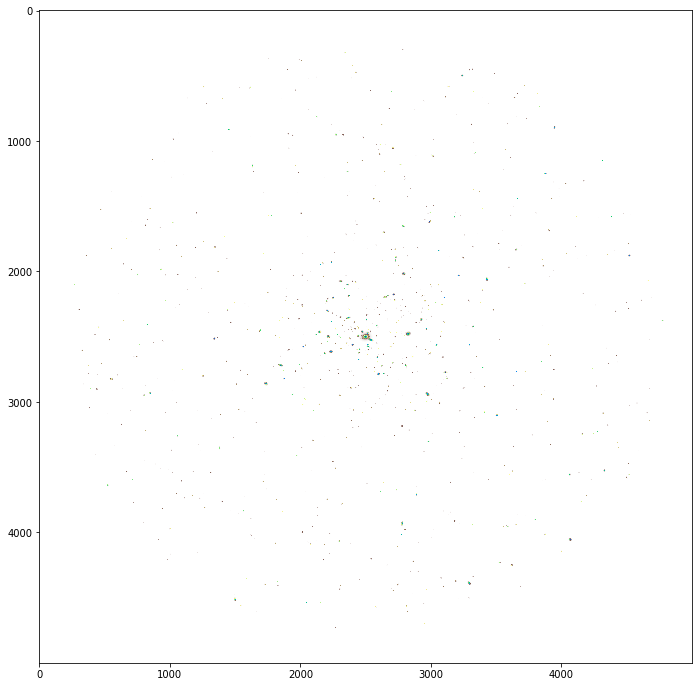

In [296]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array  + 0.001
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.terrain)

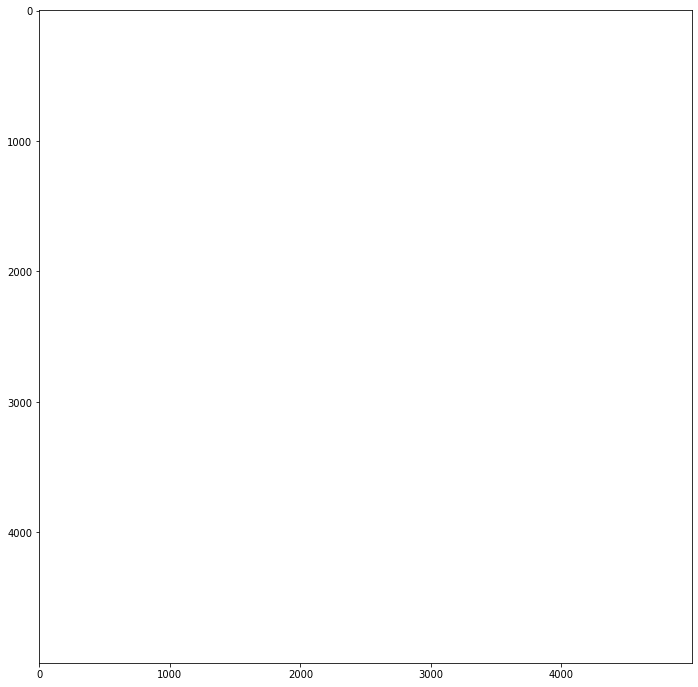

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array
ax.imshow(cc, cmap=plt.cm.gray_r)

In [7]:
def draw_image(canvas, catalog, band='g'):
    for i in np.arange(len(catalog)):
        bdf_pars = np.zeros(7)
        bdf_pars[2] = catalog["G1"][i]
        bdf_pars[3] = catalog["G2"][i]
        bdf_pars[4] = catalog["TSIZE"][i]
        bdf_pars[5] = catalog["FRACDEV"][i]
        bdf_pars[6] = catalog["FLUX_" +band.upper()][i]
        galmaker = ngmix.gmix.GMixBDF(bdf_pars)
        gs_profile = galmaker.make_galsim_object()
        final_gal = galsim.Convolve([psf, gs_profile])
        stamp_size = final_gal.getGoodImageSize(pixel_scale)

        xx = catalog['X'][i] - 2500.
        yy = catalog['Y'][i] - 2500.



        x_cen = np.floor(xx)
        y_cen = np.floor(yy)

        offset = (xx - x_cen, yy - y_cen)
        b = galsim.BoundsI(x_cen - stamp_size / 2+1  , x_cen + stamp_size/ 2,
                           y_cen - stamp_size / 2 +1,  y_cen + stamp_size / 2)
        sub_gal_image = canvas[b]
        final_gal.drawImage(sub_gal_image, offset=offset, add_to_image=True)
#         print(canvas[b].array.min(), canvas[b].array.mean())
    return canvas


In [7]:
xx = catalog['X'] - 2500.
yy = catalog['Y'] - 2500.
canvas_size = 5000.

In [8]:
pixel_scale = 0.264
sky_level = 1.e2                # ADU / arcsec^2
psf_fwhm = 0.9

In [9]:
psf = galsim.Gaussian(fwhm=0.9)

In [10]:
gal_image = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)

In [11]:
band = "g"

In [13]:
for i, band in enumerate(["g", 'r', 'i', 'z']):
    ud = galsim.UniformDeviate(31415926 + i)
    noise = galsim.GaussianNoise(ud, sigma=0.1)
    print(band)
    
    canvas = galsim.ImageF(canvas_size, canvas_size, scale=pixel_scale)
    canvas.addNoise(noise)
    canvas = draw_image(canvas, catalog_cluster, band=band)
    fio.write("image_" + band + ".fits", canvas.array)

g
r
i
z


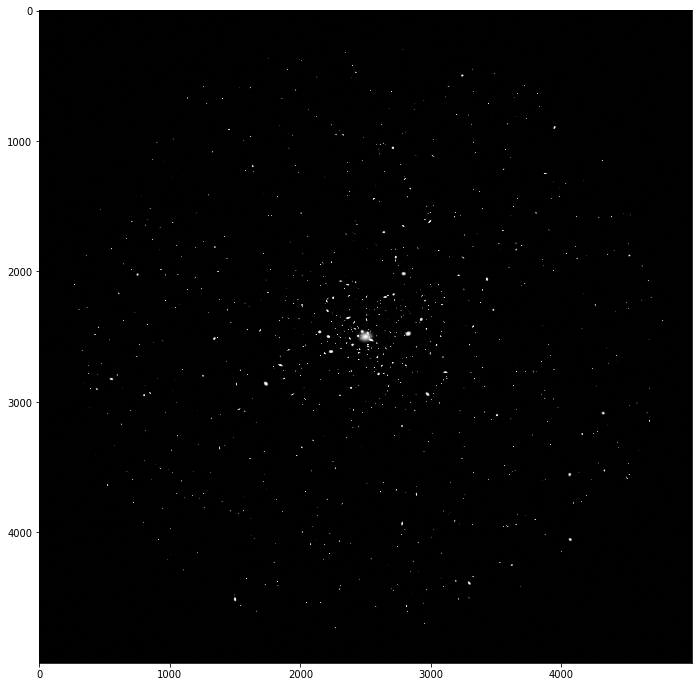

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = canvas.array
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)
# ax.imshow(canvas.array)

fig.savefig('cluster_only_test_G_v02.png', dpi=300)